In [5]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import  Input,Conv2D, MaxPooling2D
from keras.layers import Activation, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,Input, BatchNormalization, GlobalMaxPool1D,LSTM
from keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
import tensorflow_addons as tfa
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
import scipy.spatial as sp
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from scipy.stats import skew, kurtosis, iqr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error
from numpy.linalg import norm
from scipy import interpolate
import librosa
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import Sequence
import librosa.display
import cv2

Image data shape:  (12, 256, 256, 3)
X_train shape:  (8, 256, 256, 3)
X_val shape:  (2, 256, 256, 3)
X_test shape:  (2, 256, 256, 3)
y_train shape:  (8, 3)
y_val shape:  (2, 3)
y_test shape:  (2, 3)
Trying:  0 / 20
Accuracy:  0.5
Loss:  9.001907348632812
Trying:  1 / 20
Accuracy:  0.5
Loss:  21.22789764404297
Trying:  2 / 20
Accuracy:  0.5
Loss:  26.981597900390625
Trying:  3 / 20
Accuracy:  0.5
Loss:  26.232093811035156
Trying:  4 / 20
Accuracy:  0.5
Loss:  17.03697967529297
Trying:  5 / 20
Accuracy:  0.5
Loss:  13.733834266662598
Trying:  6 / 20
Accuracy:  0.5
Loss:  19.8090763092041
Trying:  7 / 20
Accuracy:  0.5
Loss:  23.41703224182129
Trying:  8 / 20
Accuracy:  0.5
Loss:  22.5216064453125
Trying:  9 / 20
Accuracy:  0.5
Loss:  3.818918228149414
Trying:  10 / 20
Accuracy:  0.5
Loss:  19.838529586791992
Trying:  11 / 20
Accuracy:  0.5
Loss:  6.828658580780029
Trying:  12 / 20
Accuracy:  0.5
Loss:  7.298015117645264
Trying:  13 / 20
Accuracy:  0.5
Loss:  1.4972230195999146
Trying:  1

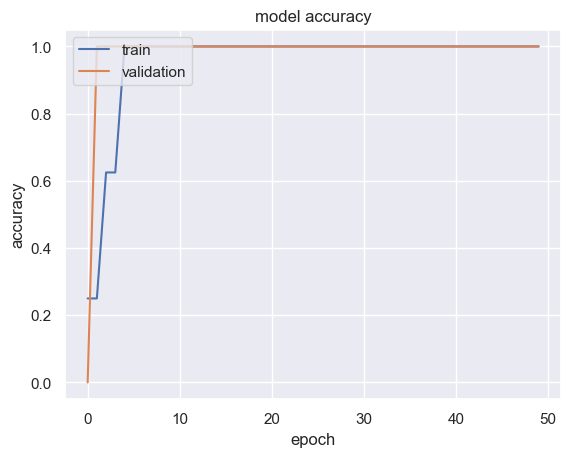

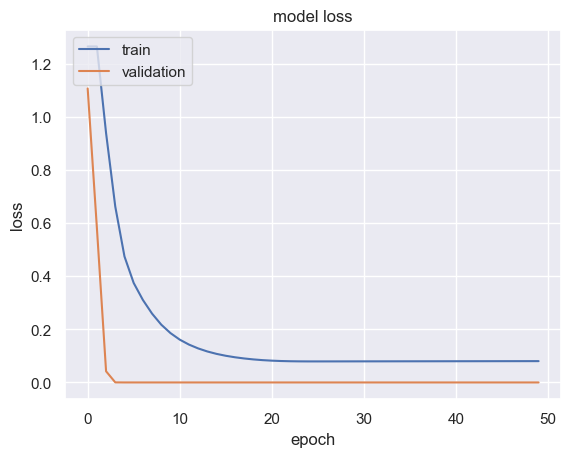

<AxesSubplot: >

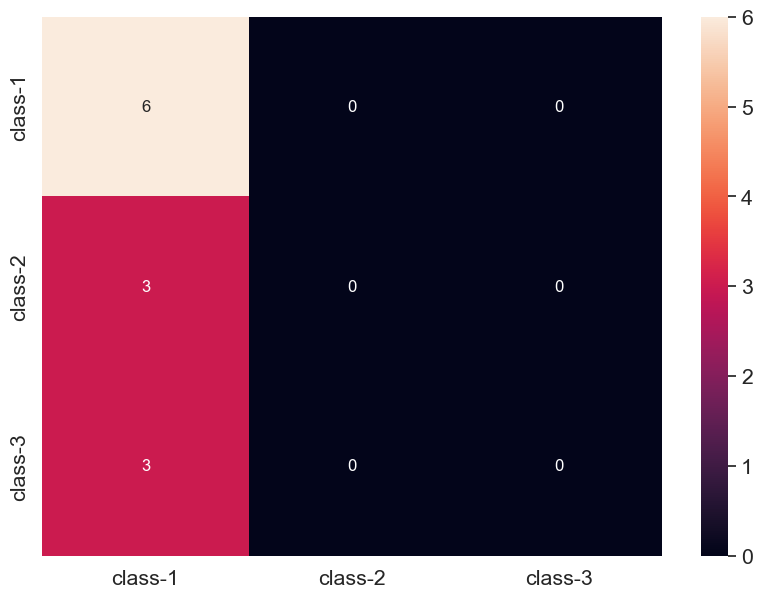

In [6]:
IMG_SIZE=256
#load data
data_X=np.load('data_X_combined.npy')
data_Y=np.load('data_Y_combined.npy')
onehot_encoded=np.load('onehot_encoded_combined.npy')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0:1], rgb[:,:,1:2], rgb[:,:,2:3]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

Cum=[]


for i in range(len(data_X)):
    Im=[]
    for j in range(data_X.shape[2]):
        img=plt.imread('images_combined\im'+str(i)+'_'+str(j)+'.jpg')
        im=img[50:1050,150:1500,:]  #crop image
        im=cv2.resize(im,(IMG_SIZE,IMG_SIZE))
        im=np.expand_dims(im,axis=-1)
        Im.append(im)

    Im=np.concatenate(Im,axis=-1)
    Cum.append(Im)

    #print progress on same line
    print("Progress: ", i, "/", len(data_X), end="\r")

Cum=np.array(Cum)
#normalize data
Cum=Cum/255.

#get sum along axis=4
Cum=np.sum(Cum,axis=4)


#get first three channels
Cum=Cum[:,:,:,0:3]

print("Image data shape: ", Cum.shape)
#split data into train, validation, and test sets in percentage 70,20,10
X_train, X_test, y_train, y_test = train_test_split(Cum, onehot_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)


BATCH_SIZE = 16
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
IMAGE_SIZE=256
NUM_CLASSES=y_train.shape[1]




#compile model

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )





tries=20
check_acc=[]
histories=[]
y_pred_bool_collect=[]
y_ref_bool_collect=[]

for trying in range(tries):
    #https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/ResNet.py
    print("Trying: ", trying, "/", tries)
    n_feature_maps=16
    input_shape=X_train.shape[1:]

    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8,1,  padding='same')(x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
        
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)

    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
        
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)

    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
        
    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(NUM_CLASSES, activation='softmax')(full)

    model = keras.models.Model(inputs=x, outputs=out)

    #-------------------------------------------------------------------------------------

    total_steps = int((len(y_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.15
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    #callbacks
    # early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)

    #train model
    history = model.fit(X_train, y_train, epochs=EPOCHS,batch_size=16, validation_data=(X_val, y_val),verbose=0)
    l,a=model.evaluate(Cum, onehot_encoded, verbose=0)
    print("Accuracy: ", a)
    print("Loss: ", l)
    y_pred = model.predict(Cum, verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_ref_bool=np.argmax(onehot_encoded, axis=1)
    y_pred_bool_collect.append(y_pred_bool)
    y_ref_bool_collect.append(y_ref_bool)
    check_acc.append(a)
    histories.append(history)


#find argmax of check_acc
ind_max_acc=np.argmax(check_acc)
print("-----------------------------------------")
print("Best accuracy: ", check_acc[ind_max_acc])
print("------------------------------------------")
history=histories[ind_max_acc]



#plot accuracy and loss
sns.set_theme(style="darkgrid")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])   
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



y_pred_bool=y_pred_bool_collect[ind_max_acc]
y_ref_bool=y_ref_bool_collect[ind_max_acc]


cm=confusion_matrix(y_ref_bool,y_pred_bool)


label_names=['class-1','class-2','class-3']

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

